
<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning" style="width: 600px">
</div>

# Understanding and Applying Quantization

Quantization is a method that can allow models to run faster and use less memory. By converting 32-bit floating-point numbers (the `float32` data type) into lower-precision formats, like 8-bit integers (the `int8` data type), we can reduce the computational requirements of our models. Let's start with the basics and gradually move towards quantizing complex models like CNNs.

### ![Dolly](https://files.training.databricks.com/images/llm/dolly_small.png) Learning Objectives
1. Explore how to quantize a a single variable and a function in pytorch
1. Apply quantization to a neural network
1. Compare the size and performance of quantized convolutional neural network 


## Classroom Setup

In [0]:
%run ../Includes/Classroom-Setup

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


Resetting the learning environment:
| enumerating serving endpoints...found 5...(0 seconds)
| No action taken

Skipping install of existing datasets to "dbfs:/mnt/dbacademy-datasets/llm-foundation-models/v01-raw"

Validating the locally installed datasets:
| listing local files...(5 seconds)
| removing extra path: /models/models--bert-base-uncased/.no_exist/86b5e0934494bd15c9632b12f734a8a67f723594/...(1 seconds)
| removing extra path: /models/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/...(0 seconds)
| removing extra path: /models/models--distilbert-base-uncased/.no_exist/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/...(0 seconds)
| removing extra path: /models/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/...(0 seconds)
| removing extra path: /models/models--gpt2-XL/.no_exist/15ea56dee5df4983c59b2538573817e1667135e2/...(0 seconds)
| removing extra path: /models/models--gpt2-XL/snapshots/15ea56dee5df4983c59b2538573817e16

Importing lab testing framework.



Using the "default" schema.

Predefined paths variables:
| DA.paths.working_dir: /dbfs/mnt/dbacademy-users/labuser5381118@vocareum.com/llm-foundation-models
| DA.paths.user_db:     dbfs:/mnt/dbacademy-users/labuser5381118@vocareum.com/llm-foundation-models/database.db
| DA.paths.datasets:    /dbfs/mnt/dbacademy-datasets/llm-foundation-models/v01-raw

Setup completed (20 seconds)

The models developed or used in this course are for demonstration and learning purposes only.
Models may occasionally output offensive, inaccurate, biased information, or harmful instructions.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import sys
import io

# Section 1 - Quantization

We'll illustrate both 4-bit and 8-bit quantization. As for the neural network part, we'll create a simple model and show how to quantize and dequantize its weights. Since we can't download data or train models in this environment, I'll present the code you would use to do it.

### 1. Quantization of a Single Value
Quantization is the process of constraining an input from a large set to output in a smaller set. In the context of deep learning, it's used to reduce the precision of the weights and activations of the neural network models. This can help to reduce the memory footprint and computational intensity of models. Here, we'll start by quantizing a single floating point number.

We'll define two functions: one to quantize a value and another to unquantize it. The quantize function will take a floating point number and a number of bits, and will output an integer representation of the input number. The unquantize function will take the integer and the number of bits, and will output the floating point number.

The range of input values for the quantize function is between -1 and 1. The range of output values for the unquantize function is also between -1 and 1. The number of bits determines the precision of the quantization. More bits means higher precision, but more memory usage. For this demonstration, we'll use 4 and 8 bits.

In [0]:
# Let's start by defining the quantize and unquantize functions:

def quantize(value, bits):
    """
    Quantizes a floating point number to an integer, given a certain number of bits.
    The range is from -1.0 to 1.0.
    
    Args:
    value (float): The value to be quantized.
    bits (int): The number of bits used for quantization.
    
    Returns:
    int: The quantized value.
    """
    assert -1.0 <= value <= 1.0, "Value out of range"
    quantized_value = np.round(value * (2**(bits - 1) - 1))
    return int(quantized_value)

def unquantize(quantized_value, bits):
    """
    Unquantizes an integer back to a floating point number, given the original number of bits.
    The range is from -1.0 to 1.0.
    
    Args:
    quantized_value (int): The value to be unquantized.
    bits (int): The number of bits used for quantization.
    
    Returns:
    float: The unquantized value.
    """
    value = quantized_value / (2**(bits - 1) - 1)
    return float(value)

In [0]:
# Test the quantize and unquantize functions with 4 and 8 bits
value = 0.5
quantized_value_4bit = quantize(value, bits=4)
unquantized_value_4bit = unquantize(quantized_value_4bit, bits=4)

quantized_value_8bit = quantize(value, bits=8)
unquantized_value_8bit = unquantize(quantized_value_8bit, bits=8)

print(f"Original Value: {value}\n----\n4-bit Quantization:{quantized_value_4bit}\n4-bit Unquantization: {unquantized_value_4bit}\n----\n8-bit Quantization:{quantized_value_8bit}\n8-bit Unquantization: {unquantized_value_8bit}")

Original Value: 0.5
----
4-bit Quantization:4
4-bit Unquantization: 0.5714285714285714
----
8-bit Quantization:64
8-bit Unquantization: 0.5039370078740157


The quantize and unquantize functions are working as expected. The float value 0.5 was quantized to 4 and 64 for 4-bit and 8-bit precision respectively. Then, the quantized values were unquantized back to approximately 0.5 (with some deviation due to the rounding operation in the quantization process).

### 2. Quantization of a Function
Now let's demonstrate quantization and unquantization with a function. To simplify, we'll use the sine function as an example. For this demonstration, we'll generate values, quantize them, and then unquantize them. We'll plot the original, quantized, and unquantized values to visualize the effects of quantization.

We'll start by generating the values of the sine function, then we'll quantize and unquantize those values. Finally, we'll plot the original, quantized, and unquantized values.

In [0]:
# # Generate values
x = np.linspace(-1, 1, 100)
y = np.sin(np.pi * x)

# Quantize and unquantize values for 4 and 8 bits
y_quantized_4bit = np.array([quantize(val, bits=4) for val in y])
y_unquantized_4bit = np.array([unquantize(val, bits=4) for val in y_quantized_4bit])

y_quantized_8bit = np.array([quantize(val, bits=8) for val in y])
y_unquantized_8bit = np.array([unquantize(val, bits=8) for val in y_quantized_8bit])

# Calculate quantization loss for 4 and 8 bits
loss_4bit = np.mean((y - y_unquantized_4bit)**2)
loss_8bit = np.mean((y - y_unquantized_8bit)**2)

print(f"Loss of 4-bit quantization: {loss_4bit}\nLoss of 8-bit quantization: {loss_8bit}")

Loss of 4-bit quantization: 0.001522312728708395
Loss of 8-bit quantization: 4.5269879932343545e-06


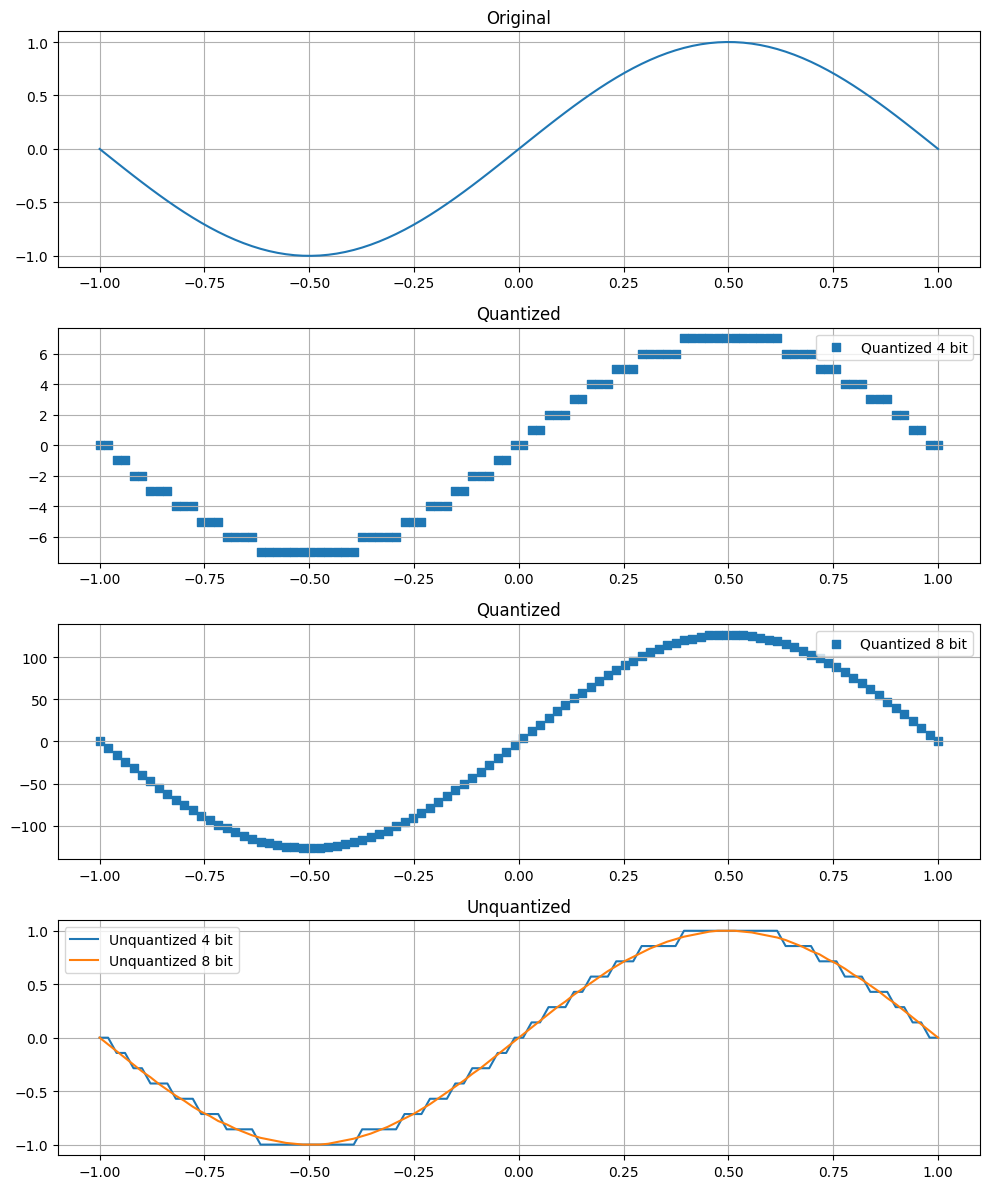

In [0]:
# Plot original, quantized and unquantized values
plt.figure(figsize=(10, 12))

plt.subplot(4, 1, 1)
plt.plot(x, y, label="Original")
plt.title("Original")
plt.grid(True)

plt.subplot(4, 1, 2)
plt.scatter(x, y_quantized_4bit, label="Quantized 4 bit", marker="s")
plt.legend()
plt.title("Quantized")
plt.grid(True)

plt.subplot(4, 1, 3)
plt.scatter(x, y_quantized_8bit, label="Quantized 8 bit", marker="s")
plt.legend()
plt.title("Quantized")
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(x, y_unquantized_4bit, label="Unquantized 4 bit")
plt.plot(x, y_unquantized_8bit, label="Unquantized 8 bit")
plt.legend()
plt.title("Unquantized")
plt.grid(True)

plt.tight_layout()
plt.show()

The plots illustrate the original sine function, the 4-bit and 8-bit quantized values, and their unquantized counterparts.

The 'Quantized' plot clearly shows the "step" pattern of the quantized values. The 8-bit quantized values have more levels and are closer to the original function compared to the 4-bit values, which have fewer levels and deviate more.

The 'Unquantized' plot shows the values obtained by converting the quantized values back to floating-point numbers. The 8-bit unquantized values are very close to the original function, while the 4-bit unquantized values deviate more due to the reduced precision.

### 3. Quantization of a Simple Neural Network
Next, let's apply quantization to a neural network. We'll create a simple network with one hidden layer, then we'll quantize and dequantize its weights.

In PyTorch, [quantization](https://pytorch.org/docs/stable/quantization.html) is achieved using a `QuantStub` and `DeQuantStub` to mark the points in the model where the data needs to be converted to quantized form and converted back to floating point form, respectively. After defining the network with these stubs, we use the `torch.quantization.prepare` and `torch.quantization.convert` functions to quantize the model.

The process of quantizing a model in PyTorch involves the following steps:

- Define a neural network and mark the points in the model where the data needs to be converted to quantized form and converted back to floating point form. This is done using a `QuantStub` and `DeQuantStub`.
- Specify a quantization configuration for the model using `torch.quantization.get_default_qconfig`. This sets up the quantization parameters.
- Prepare the model for quantization using `torch.quantization.prepare`. This function replaces specified modules in the model with their quantized counterparts.
- Calibrate the model on a calibration dataset. During calibration, the model is run on a calibration dataset and the range of the activations is observed. This is used to determine the parameters for quantization.
- Convert the prepared and calibrated model to a quantized version using torch.quantization.convert. This function changes these modules to use quantized weights.

In [0]:
# Define the network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # QuantStub will act as a placeholder for the quantization process, it simulates quantization of inputs to the model.
        self.quant = torch.quantization.QuantStub()
        
        # Define two fully connected layers (aka linear layers) for our simple neural network
        self.fc1 = nn.Linear(28 * 28, 128)  # Input size is 28*28 (size of a flattened MNIST image), output size is 128
        self.fc2 = nn.Linear(128, 10)  # Input size is 128 (output of previous layer), output size is 10 (for 10 classes)

        # DeQuantStub simulates the dequantization of the final output of the model, converting it back to a floating point number.
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        # Reshape the input tensor to a vector of size 28*28
        x = x.view(-1, 28 * 28)
        
        # Pass the input through the QuantStub, which will simulate the quantization of the input tensor
        x = self.quant(x)
        
        # Apply the first fully connected layer and ReLU activation function
        x = torch.relu(self.fc1(x))
        
        # Apply the second fully connected layer
        x = self.fc2(x)
        
        # Pass the output through the DeQuantStub, which will simulate the dequantization of the output tensor
        x = self.dequant(x)
        
        return x

In [0]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainset = torchvision.datasets.MNIST(root=DA.paths.working_dir, train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Define loss function and optimizer
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

Failed to download (trying next):
<urlopen error [Errno 101] Network is unreachable>



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /dbfs/mnt/dbacademy-users/labuser5381118@vocareum.com/llm-foundation-models/MNIST/raw/train-images-idx3-ubyte.gz to /dbfs/mnt/dbacademy-users/labuser5381118@vocareum.com/llm-foundation-models/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 101] Network is unreachable>



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /dbfs/mnt/dbacademy-users/labuser5381118@vocareum.com/llm-foundation-models/MNIST/raw/train-labels-idx1-ubyte.gz to /dbfs/mnt/dbacademy-users/labuser5381118@vocareum.com/llm-foundation-models/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 101] Network is unreachable>



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /dbfs/mnt/dbacademy-users/labuser5381118@vocareum.com/llm-foundation-models/MNIST/raw/t10k-images-idx3-ubyte.gz to /dbfs/mnt/dbacademy-users/labuser5381118@vocareum.com/llm-foundation-models/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 101] Network is unreachable>



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /dbfs/mnt/dbacademy-users/labuser5381118@vocareum.com/llm-foundation-models/MNIST/raw/t10k-labels-idx1-ubyte.gz to /dbfs/mnt/dbacademy-users/labuser5381118@vocareum.com/llm-foundation-models/MNIST/raw



In [0]:
# Train the network
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print("[%d, %5d] loss: %.3f" %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print("Finished Training")

[1,   200] loss: 1.175
[1,   400] loss: 0.509
[1,   600] loss: 0.410
[1,   800] loss: 0.365
[2,   200] loss: 0.322
[2,   400] loss: 0.303
[2,   600] loss: 0.302
[2,   800] loss: 0.286
Finished Training


In [0]:
# Specify quantization configuration
net.qconfig = torch.ao.quantization.get_default_qconfig("onednn")

# Prepare the model for static quantization. This inserts observers in the model that will observe activation tensors during calibration.
net_prepared = torch.quantization.prepare(net)

# Now we convert the model to a quantized version.
net_quantized = torch.quantization.convert(net_prepared)

# Once the model is quantized, it can be used for inference in the same way as the unquantized model, but it will use less memory and potentially have faster inference times, at the cost of a possible decrease in accuracy.

/databricks/python/lib/python3.10/site-packages/torch/ao/quantization/observer.py:1204: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


In [0]:
# Let's look at the sizes of these two models on disk and see how much we save by quantization
buf = io.BytesIO()
torch.save(net.state_dict(), buf)
size_original = sys.getsizeof(buf.getvalue())

buf = io.BytesIO()
torch.save(net_quantized.state_dict(), buf)
size_quantized = sys.getsizeof(buf.getvalue())

print("Size of the original model: ", size_original)
print("Size of the quantized model: ", size_quantized)
print(f"The quantized model is {np.round(100.*(size_quantized )/ size_original)}% the size of the original model")

Size of the original model:  408576
Size of the quantized model:  108572
The quantized model is 27.0% the size of the original model


In [0]:
# Print out the weights of the original network
for name, param in net.named_parameters():
    print("Original Network Layer:", name)
    print(param.data)

Original Network Layer: fc1.weight
tensor([[ 1.5743e-02,  3.4109e-02,  1.4325e-02,  ..., -2.4922e-02,
         -1.5986e-02,  6.4373e-03],
        [ 1.9459e-03,  1.7184e-02,  8.8843e-03,  ...,  3.4305e-02,
         -9.7882e-03,  2.6398e-03],
        [ 2.7140e-02, -2.5785e-02,  1.3935e-02,  ..., -7.3633e-03,
          2.8729e-02, -2.4027e-02],
        ...,
        [ 3.7604e-03, -1.4078e-02, -1.3944e-02,  ...,  1.7237e-03,
          4.0080e-04,  1.4958e-02],
        [ 1.6119e-02,  2.2101e-02, -2.0608e-02,  ...,  3.2613e-02,
         -1.2001e-02, -1.6029e-02],
        [-2.1372e-02, -4.7662e-04,  1.7498e-02,  ...,  2.3867e-05,
          2.3390e-02, -1.8204e-02]])
Original Network Layer: fc1.bias
tensor([-0.0138,  0.0231, -0.0282, -0.0286, -0.0122,  0.0322, -0.0095, -0.0234,
         0.0338, -0.0237, -0.0224,  0.0436, -0.0143, -0.0154,  0.0030, -0.0101,
        -0.0145,  0.0322,  0.0405,  0.0376, -0.0333, -0.0228,  0.0164,  0.0099,
        -0.0263,  0.0041,  0.0071,  0.0037,  0.0400,  0.0035

In [0]:
# Print out the weights of the quantized network
for name, module in net_quantized.named_modules():
    if isinstance(module, nn.quantized.Linear):
        print("Quantized Network Layer:", name)
        
        print("Weight:")
        print(module.weight())
        
        print("Bias:")
        print(module.bias)


Quantized Network Layer: fc1
Weight:
tensor([[ 0.0158,  0.0341,  0.0143,  ..., -0.0250, -0.0161,  0.0066],
        [ 0.0019,  0.0170,  0.0089,  ...,  0.0344, -0.0097,  0.0027],
        [ 0.0272, -0.0258,  0.0141,  ..., -0.0075,  0.0286, -0.0239],
        ...,
        [ 0.0039, -0.0141, -0.0141,  ...,  0.0018,  0.0004,  0.0148],
        [ 0.0162,  0.0221, -0.0208,  ...,  0.0325, -0.0117, -0.0162],
        [-0.0211, -0.0006,  0.0177,  ...,  0.0000,  0.0234, -0.0183]],
       size=(128, 784), dtype=torch.qint8,
       quantization_scheme=torch.per_channel_affine,
       scale=tensor([0.0004, 0.0004, 0.0005, 0.0006, 0.0004, 0.0004, 0.0004, 0.0005, 0.0005,
        0.0006, 0.0005, 0.0005, 0.0003, 0.0007, 0.0006, 0.0005, 0.0003, 0.0006,
        0.0006, 0.0003, 0.0004, 0.0006, 0.0008, 0.0004, 0.0006, 0.0004, 0.0006,
        0.0004, 0.0005, 0.0004, 0.0005, 0.0005, 0.0005, 0.0004, 0.0004, 0.0005,
        0.0005, 0.0006, 0.0005, 0.0006, 0.0004, 0.0004, 0.0004, 0.0006, 0.0004,
        0.0007, 0.00

#### Comparing a Quantized and Non-Quantized Model

Here is a summary of the details and a comparison with the original model:

- `Tensor Values`: In the quantized model, these are quantized values of the weights and biases, compared to the original model which stores these in floating point precision. These values are used in the computations performed by the layer, and they directly affect the layer's output.
- `Size`: This is the shape of the weight or bias tensor and it should be the same in both the original and quantized model. In a fully-connected layer, this corresponds to the number of neurons in the current layer and the number of neurons in the previous layer.
- `Dtype`: In the original model, the data type of the tensor values is usually torch.float32 (32-bit floating point), whereas in the quantized model it is a quantized data type like torch.qint8 (8-bit quantized integer). This reduces the memory usage and computational requirements of the model.
- `Quantization_scheme`: This is specific to the quantized model. It is the type of quantization used, for example, torch.per_channel_affine means different channels (e.g., neurons in a layer) can have different scale and zero_point values.
- `Scale & Zero Point`: These are parameters of the quantization process and are specific to the quantized model. They are used to convert between the quantized and dequantized forms of the tensor values.
- `Axis`: This indicates the dimension along which the quantization parameters vary. This is also specific to the quantized model.
- `Requires_grad`: This indicates whether the tensor is a model parameter that is updated during training. It should be the same in both the original and quantized models.

In [0]:
# Suppose we have some input data
input_data = torch.randn(1, 28 * 28)

# We can pass this data through both the original and quantized models
output_original = net(input_data)
output_quantized = net_quantized(input_data)

# The outputs should be similar, because the quantized model is a lower-precision
# approximation of the original model. However, they won't be exactly the same
# because of the quantization process.
print("Output from original model:", output_original.data)
print("Output from quantized model:", output_quantized.data)

Output from original model: tensor([[-0.6263, -0.1748,  1.0647,  0.0740, -0.8856,  1.0366, -0.7912, -0.2698,
          0.7757, -0.9185]])
Output from quantized model: tensor([[1., 0., 1., 0., 0., 0., 0., 0., 1., 0.]])


In [0]:
# The difference between the outputs is an indication of the "quantization error",
# which is the error introduced by the quantization process.
quantization_error = (output_original - output_quantized).abs().mean()
print("Quantization error:", quantization_error)

Quantization error: tensor(0.6066, grad_fn=<MeanBackward0>)


In [0]:
# The weights of the original model are stored in floating point precision, so they
# take up more memory than the quantized weights. We can check this using the
# `element_size` method, which returns the size in bytes of one element of the tensor.
print(f"Size of one weight in original model: {net.fc1.weight.element_size()} bytes (32bit)")
print(f"Size of one weight in quantized model: {net_quantized.fc1.weight().element_size()} byte (8bit)")

Size of one weight in original model: 4 bytes (32bit)
Size of one weight in quantized model: 1 byte (8bit)



This example shows how the quantized model can be used in the same way as the original model. It also demonstrates the trade-off between precision and memory usage/computation speed that comes with quantization. The quantized model uses less memory and is faster to compute, but the outputs are not exactly the same as the original model due to the quantization error.

&copy; 2023 Databricks, Inc. All rights reserved.<br/>
Apache, Apache Spark, Spark and the Spark logo are trademarks of the <a href="https://www.apache.org/">Apache Software Foundation</a>.<br/>
<br/>
<a href="https://databricks.com/privacy-policy">Privacy Policy</a> | <a href="https://databricks.com/terms-of-use">Terms of Use</a> | <a href="https://help.databricks.com/">Support</a>